In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

### Classifier models

1. [Tree](#tree)
2. [Forest](#forest)
3. [kNN](#knn)
4. [Logistic](#log)

In [2]:
df = pd.read_csv("titanic.csv", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passenger_id  891 non-null    int64  
 1   survived      891 non-null    int64  
 2   pclass        891 non-null    int64  
 3   sex           891 non-null    object 
 4   age           714 non-null    float64
 5   sibsp         891 non-null    int64  
 6   parch         891 non-null    int64  
 7   fare          891 non-null    float64
 8   embarked      889 non-null    object 
 9   class         891 non-null    object 
 10  deck          203 non-null    object 
 11  embark_town   889 non-null    object 
 12  alone         891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 97.5+ KB


In [3]:
#missing values
np.sum(df.isna())

passenger_id      0
survived          0
pclass            0
sex               0
age             177
sibsp             0
parch             0
fare              0
embarked          2
class             0
deck            688
embark_town       2
alone             0
dtype: int64

In [4]:
#there
df.age = df.age.fillna(df.age.mean())

In [5]:
df=df.drop(columns=['deck', 'embark_town'])
df=df.dropna(axis=0)

In [6]:
df2=pd.get_dummies(df, drop_first=True)
labels=df2.pop('survived')

In [7]:
df2.head()

,passenger_id,pclass,age,sibsp,parch,fare,alone,sex_male,embarked_Q,embarked_S,class_Second,class_Third
0,0,3,22.0,1,0,7.2500,0,1,0,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0,0,0,0
2,2,3,26.0,0,0,7.9250,1,0,0,1,0,1
3,3,1,35.0,1,0,53.1000,0,0,0,1,0,0
4,4,3,35.0,0,0,8.0500,1,1,0,1,0,1


In [8]:
df2=df2.drop(columns=['pclass'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df2, labels, test_size=.17,
                                                    random_state=36, stratify=labels)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=17/83,
                                                  random_state=36, stratify=y_train)

In [10]:
over = RandomOverSampler(random_state=36)
X_ros, y_ros = over.fit_resample(X_train, y_train)
smote = SMOTE(random_state=36)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_dev.shape, y_dev.shape, X_ros.shape, y_ros.shape

((586, 11), (586,), (152, 11), (152,), (151, 11), (151,), (724, 11), (724,))

#### Baseline Model and accuracy

In [243]:
df.survived.value_counts()

0    549
1    340
Name: survived, dtype: int64

In [244]:
base = np.zeros(len(X_train)) #baseline: Jacked
round(sum(base==y_train)/len(X_train),2) #accuracy

0.62

<a id='tree'></a>
### Tree

0.8410596026490066


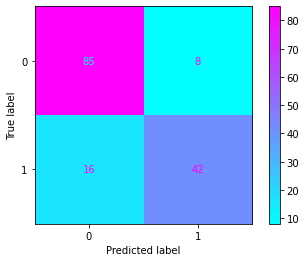

In [15]:
#cost complexity pruning removes nodes based on impurity; node complexities above alpha get pruned
dt = DecisionTreeClassifier(max_leaf_nodes=7, ccp_alpha=.007, random_state=36)
dt.fit(X_train, y_train)
print(dt.score(X_dev, y_dev)) #accuracy
plot_confusion_matrix(dt, X_dev, y_dev, cmap='cool');      

0.8079470198675497


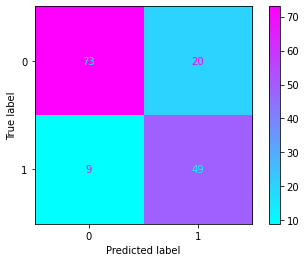

In [16]:
#does 0versampling help?
dt_sample = DecisionTreeClassifier(ccp_alpha=.007, random_state=36)
dt_sample.fit(X_ros, y_ros)
print(dt_sample.score(X_dev, y_dev)) #accuracy
plot_confusion_matrix(dt_sample, X_dev, y_dev, cmap='cool'); #maybe not

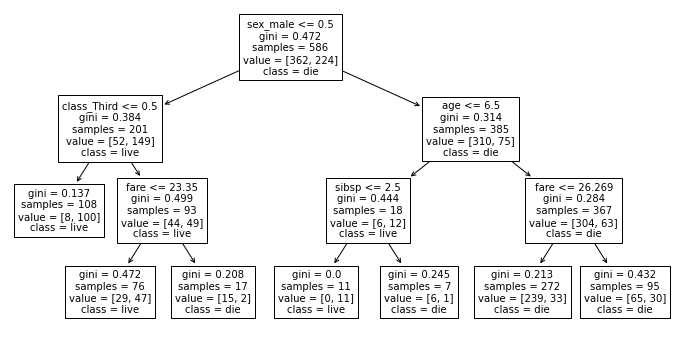

In [18]:
f = plt.subplots(figsize=(12,6))
#good tree
plot_tree(dt, feature_names=df2.columns, class_names=['die','live']);

In [19]:
pred = dt.predict(X_dev)
#calculates precision, recall, F1, support
print(classification_report(y_dev, pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.88        93
           1       0.84      0.72      0.78        58

    accuracy                           0.84       151
   macro avg       0.84      0.82      0.83       151
weighted avg       0.84      0.84      0.84       151



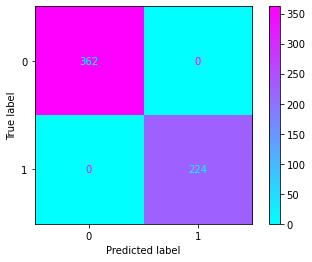

In [20]:
dt_overfit = DecisionTreeClassifier(random_state=36)
dt_overfit.fit(X_train, y_train)
#this overgrown tree badly overfit the training data
plot_confusion_matrix(dt_overfit, X_train, y_train, cmap='cool');

0.7615894039735099


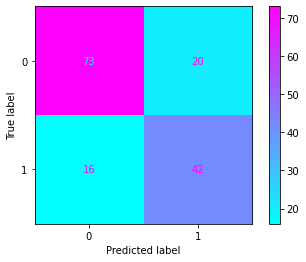

In [260]:
#not so hot on non-training data
print(dt_overfit.score(X_dev, y_dev)) #accuracy
plot_confusion_matrix(dt_overfit, X_dev, y_dev, cmap='cool');

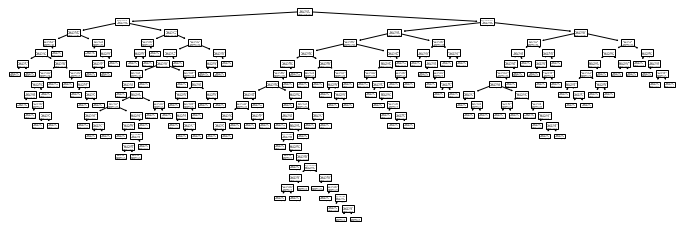

In [86]:
f = plt.subplots(figsize=(12,4))
#this is more convoluted than a stalker's pinboard; deosn't generalize to new, unseen data
plot_tree(dt_overfit);

<a id='forest'></a>
### Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import eli5

In [22]:
rf = RandomForestClassifier(min_samples_leaf=1, max_depth=10,random_state=36)
rf.fit(X_train, y_train)
rf.score(X_dev, y_dev)

0.8344370860927153

In [82]:
pred = rf.predict(X_dev)
print(classification_report(y_dev, pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        93
           1       0.81      0.74      0.77        58

    accuracy                           0.83       151
   macro avg       0.83      0.82      0.82       151
weighted avg       0.83      0.83      0.83       151



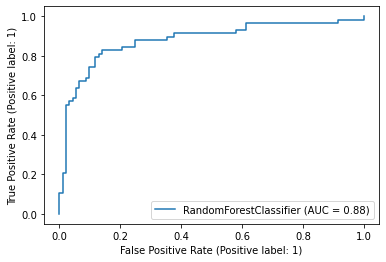

In [14]:
#tpr(sensitivity) and tnr(specificity)
plot_roc_curve(rf, X_dev, y_dev); #AUC = .88

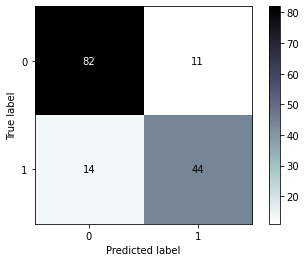

In [15]:
plot_confusion_matrix(rf, X_dev, y_dev, cmap='bone_r');

0.9607508532423208


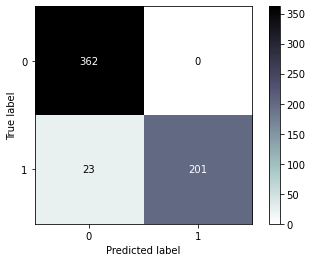

In [16]:
#the default forest also overfits but maybe not as severely as the lone tree
print(rf.score(X_train, y_train))
plot_confusion_matrix(rf, X_train, y_train, cmap='bone_r');

In [29]:
#random grid search for better hyperparameters
param_dict = {"min_samples_leaf":[1,2,4,8,16],
              "max_depth":[2,4,8,16,32],
              "n_estimators": [50,100,200,400,800],
              "min_samples_split": [1,2,4]}
rf_rand = RandomizedSearchCV(estimator=RandomForestClassifier(),
                               param_distributions=param_dict,
                               n_iter=50, cv = 3, verbose=2, random_state=36, n_jobs=-1)
rf_rand.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/stevennewton/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.77808303 0.78833072 0.76784406 0.78492063
 0.77125414        nan 0.77124542        nan 0.79689517        nan
 0.77806559 0.79346764 0.76782662 0.77470783 0.77469039        nan
 0.79858713        nan 0.78834816 0.78662132 0.77813536        nan
        nan        nan 0.788322          nan 0.7951596  0.77466422
        nan        nan 0.77981859        nan        nan 0.79006628
 0.77125414 0.77466422 0.77983604        nan 0.79346764 0.79518577
 0.77472527 0.76271586 0.77124542        nan 0.788322          nan
        nan 0.77296354]
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 8, 16, 32],
                                        'min_samples_leaf': [1, 2, 4, 8, 16],
                                        'min_samples_split': [1, 2, 4],
                                        'n_estimators': [50, 100, 200, 400,
                                                         800]},
                   random_state=36, verbose=2)

In [32]:
params = rf_rand.best_params_
params

{'n_estimators': 100,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_depth': 4}

In [33]:
rf2 = RandomForestClassifier(**params, random_state=36) #unpack dictionary
rf2.fit(X_train, y_train)
rf2.score(X_dev, y_dev) #better

0.8543046357615894

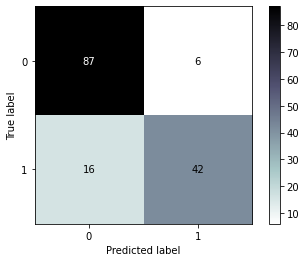

In [34]:
#best model yet after I dropped extra pclass. struggles more with survivors prol because it is the minority class
#we might try balancing the classes
plot_confusion_matrix(rf2, X_dev, y_dev, cmap='bone_r');

0.8344370860927153


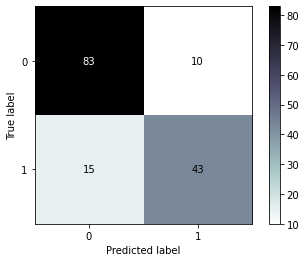

In [37]:
#using synthetic data
rf_smote = RandomForestClassifier(**params, random_state=36)
rf_smote.fit(X_smote, y_smote)
print(rf_smote.score(X_dev, y_dev)) #accuracy
plot_confusion_matrix(rf_smote, X_dev, y_dev, cmap='bone_r'); #not better

In [38]:
#feature importance ranking
eli5.show_weights(rf2, feature_names=list(X_train.columns))

Weight,Feature
0.4707 ± 0.4128,sex_male
0.1756 ± 0.3070,fare
0.1134 ± 0.2403,class_Third
0.0641 ± 0.1152,age
0.0502 ± 0.0951,passenger_id
0.0383 ± 0.0943,sibsp
0.0303 ± 0.1113,alone
0.0219 ± 0.0711,parch
0.0162 ± 0.0600,embarked_S
0.0157 ± 0.0542,class_Second


In [39]:
pred = rf2.predict(X_dev)
print(classification_report(y_dev, pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        93
           1       0.88      0.72      0.79        58

    accuracy                           0.85       151
   macro avg       0.86      0.83      0.84       151
weighted avg       0.86      0.85      0.85       151



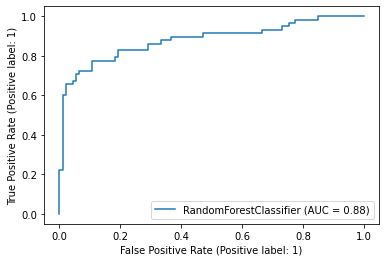

In [40]:
#tpr(sensitivity) and tnr(specificity)
plot_roc_curve(rf2, X_dev, y_dev); #AUC = .88

<a id='knn'></a>
### Nearest Neighbors

In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
#not the most promising
scores_out, scores_in = [], []
k_values = range(1,50)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    scores_out.append(round(knn.score(X_dev, y_dev),3))
    scores_in.append(round(knn.score(X_train, y_train),3))    

With few neighbors (less than 5), the model overfits the training; training set accuracy is significantly higher than dev set accuracy. Increasing k appears to improve the model on dev set data until about 35 neighbors. After this point, accuracy on both sets drops slowly indicating increasing bias. This is the case because the model is pulling in too many values to make the comparison

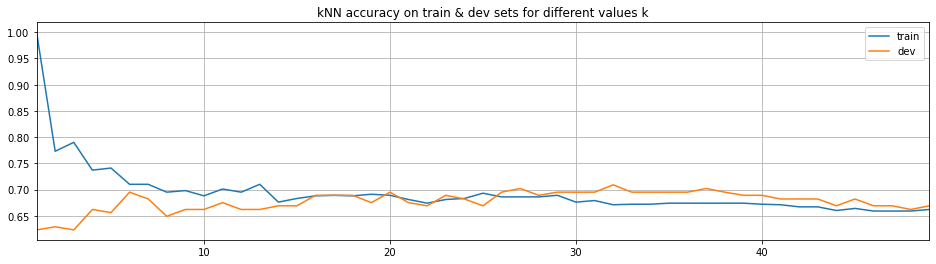

In [16]:
f = plt.subplots(figsize=(16,4))
plt.plot(k_values, scores_in)
plt.plot(k_values, scores_out)
plt.grid()
plt.xlim(1,49)
plt.legend(["train","dev"])
plt.title("kNN accuracy on train & dev sets for different values k");

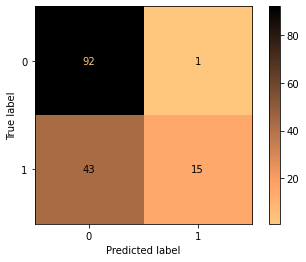

In [18]:
#almost all errors on survived class, low recall
knn = KNeighborsClassifier(n_neighbors=k_values[np.argmax(scores_out)])
knn.fit(X_train, y_train)
plot_confusion_matrix(knn, X_dev, y_dev, cmap='copper_r');

In [83]:
pred = knn.predict(X_dev)
print(classification_report(y_dev, pred))

              precision    recall  f1-score   support

           0       0.68      0.99      0.81        93
           1       0.94      0.26      0.41        58

    accuracy                           0.71       151
   macro avg       0.81      0.62      0.61       151
weighted avg       0.78      0.71      0.65       151



<a id='log'></a>
### Logistic regression

In [44]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [91]:
#the CV version does some automatic tuning
lr = make_pipeline(StandardScaler(), LogisticRegressionCV(random_state=36))
lr.fit(X_train, y_train)
lr.score(X_dev, y_dev)

0.8145695364238411

In [92]:
pred = lr.predict(X_dev)
print(classification_report(y_dev, pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85        93
           1       0.77      0.74      0.75        58

    accuracy                           0.81       151
   macro avg       0.80      0.80      0.80       151
weighted avg       0.81      0.81      0.81       151



In [101]:
#feature importance ranking
#there are good death features but no good predictors for living, meaning living, from a group perspective, is indiscriminate but dying is biased
#It's like the Titanic chopped down the bigger classes and leveled em
eli5.show_weights(lr, feature_names=list(X_train.columns))

Weight?,Feature
+0.061,fare
+0.028,passenger_id
-0.029,embarked_Q
-0.154,embarked_S
-0.234,parch
-0.370,alone
-0.380,class_Second
-0.455,age
-0.540,sibsp
-0.643,<BIAS>


In [111]:
print(df.value_counts("pclass"))
#In fact, this is true. The survivors are much more balanced than than the original boarders.
print(df[df.survived==1].value_counts("pclass"))
print(df[df.survived==0].value_counts("pclass"))

pclass
3    491
1    214
2    184
dtype: int64
pclass
1    134
3    119
2     87
dtype: int64
pclass
3    372
2     97
1     80
dtype: int64


In [112]:
print(df.value_counts("sex"))
#A lot more men got on the doomed ship. By the end women outnumbered them 2 to 1.
print(df[df.survived==1].value_counts("sex"))
print(df[df.survived==0].value_counts("sex"))

sex
male      577
female    312
dtype: int64
sex
female    231
male      109
dtype: int64
sex
male      468
female     81
dtype: int64


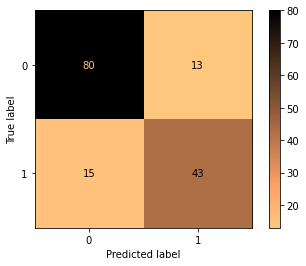

In [93]:
plot_confusion_matrix(lr, X_dev, y_dev, cmap='copper_r');

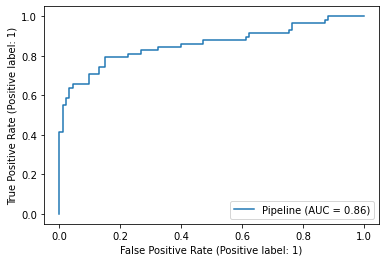

In [94]:
#tpr(sensitivity) and tnr(specificity)
plot_roc_curve(lr, X_dev, y_dev); #AUC = .86

In [95]:
X_train.columns

Index(['passenger_id', 'age', 'sibsp', 'parch', 'fare', 'alone', 'sex_male',
       'embarked_Q', 'embarked_S', 'class_Second', 'class_Third'],
      dtype='object')

In [97]:
vars=['class_Third','age', 'fare']
small_train, small_dev = X_train[vars], X_dev[vars]

In [98]:
#predicitng with 3 features is better than baseline
lr2 = LogisticRegression(random_state=36)
lr2.fit(small_train, y_train)
lr2.score(small_dev, y_dev)

0.695364238410596

In [99]:
vars=['class_Third','age', 'fare', 'sex_male']
small_train, small_dev = X_train[vars], X_dev[vars]

In [100]:
#predicitng with 4 features is much better than baseline
lr2 = LogisticRegression(random_state=36)
lr2.fit(small_train, y_train)
lr2.score(small_dev, y_dev)

0.8211920529801324